In [48]:
import functions.github_fetching as fetcher
import functions.data_cleaning as cleaner
from pysentimiento import create_analyzer 
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

In [24]:
repo_name = 'tukaani-project/xz'
repo_folder = repo_name.replace('/', '_') + '/'

control_start_date = "2021-01-01"
treatment_end_date = "2024-03-28"
cutoff_date = "2022-10-28"

In [25]:
issue_pr_location = fetcher.fetch_issues_pr(repo_name=repo_name, folder_location = repo_folder, start_date= control_start_date, end_date= treatment_end_date)
cleaner.clean_thread(issue_pr_location)

Fetching Issues and PRs for tukaani-project/xz
Total 31 issue fetched
Total 30 pr fetched
----------------------------------------------
Data Cleaning in Progress
Total 68 files cleaned
Total 530 messages cleaned
----------------------------------------------


In [30]:
def get_sentiment_score(sentiment_result):
    """
    Determine sentiment label and score based on sentiment probabilities.
    """
    sentiment_score = sentiment_result.probas['POS']*1 + sentiment_result.probas['NEG']*(-1)
    sentiment = "NEU"
    if sentiment_score > 0.2:
        sentiment = "POS"
    elif sentiment_score < -0.2:
        sentiment = "NEG"
    return sentiment, sentiment_score

def reformat_issue_pr_timestamp(date_str):
    """
    If your Issue/PR timestamps look like '2024-03-29T23:25:37Z' or
    '2024-03-29 23:25:37', parse them, convert to UTC, reformat to ISO.
    """
    # Use flexible parser to handle normal formats
    dt = pd.to_datetime(date_str, errors="coerce", utc=True)
    # Return as ISO-8601 with 'Z' suffix
    return dt.strftime("%Y-%m-%d %H:%M:%S") if pd.notna(dt) else None

def sentiment_analysis(source_path='tukaani-project_xz/'):
    """
    Perform both message and post-level sentiment analysis. 
    Returns a DataFrame (post_sentiment_results) and a DataFrame (user_interactions)
    containing columns: date, file_name, from, target, sentiment, sentiment_score.
    """

    # Paths for issues+PR and mailing list
    folder_path = os.path.join(source_path, "individual_issue_PR/")
    ml_path = os.path.join("mailing_list/", "individual_ml_convo")

    # Create the sentiment analyzer
    analyzer = create_analyzer(task="sentiment", lang="en")

    user_interactions_list = []  # We'll build a row for each message

    count = 0
    print("Running sentiment analysis...")

    # 1. Process each file in the Issues+PR folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            sentiment_score_total = 0
            num_messages = 0

            for index, row in df.iterrows():
                source_author = row.get('from', 'Unknown')
                target_authors = row.get('to', [])
                if not isinstance(target_authors, list):

                    target_authors = [target_authors]

                text = str(row.get('body', ''))
                date = row.get('created_at', '')
                result = analyzer.predict(text)
                sentiment, sentiment_score = get_sentiment_score(result)

                sentiment_score_total += sentiment_score
                num_messages += 1

                # Add a row for each target in user_interactions_list
                for target in target_authors:
                    user_interactions_list.append({
                        "date": date,
                        "file_name": filename,
                        "from": source_author,
                        "target": target,
                        "sentiment": sentiment,
                        "sentiment_score": sentiment_score
                    })
            count += 1
            
    # Convert user_interactions_list to DataFrame with desired columns
    user_interactions = pd.DataFrame(user_interactions_list, columns=[
        "date", "file_name", "from", "target", "sentiment", "sentiment_score"
    ])
    
    user_interactions["date"] = user_interactions["date"].apply(reformat_issue_pr_timestamp)
    user_interactions["date"] = pd.to_datetime(user_interactions["date"])

    return user_interactions

In [31]:
user_interactions = sentiment_analysis(source_path = repo_folder)

Running sentiment analysis...


In [20]:
user_interactions

,date,file_name,from,target,sentiment,sentiment_score
0,2024-03-30 00:23:17,issue_102.csv,nullyfae,['nullyfae'],NEU,-0.110173
1,2024-03-30 00:25:41,issue_102.csv,AffSeda,['nullyfae'],NEG,-0.803194
2,2024-03-30 00:26:39,issue_102.csv,Theldus,['AffSeda'],NEG,-0.733481
3,2024-03-30 00:46:52,issue_102.csv,nullyfae,AffSeda,POS,0.516297
4,2024-04-09 21:26:34,issue_102.csv,doclic,['nullyfae'],NEG,-0.850267
...,...,...,...,...,...,...
525,2024-03-29 23:40:03,pr_95.csv,MammaUauua,['lcarilla'],POS,0.383555
526,2024-03-29 23:41:26,pr_95.csv,MammaUauua,['lcarilla'],NEG,-0.202994
527,2024-03-29 23:43:11,pr_95.csv,skull-squadron,Alcaro,NEG,-0.758330
528,2024-03-29 22:32:58,pr_97.csv,oswalpalash,['oswalpalash'],POS,0.758579


In [42]:
def social_rdd_df_preprocess(user_interactions, control_start_date, treatment_end_date, cutoff_date):
    """
    Preprocess user interactions DataFrame for RDD analysis.
    """
    # Filter for interactions within the RDD window
    
    if isinstance(control_start_date, str):
        control_start_date = pd.to_datetime(control_start_date)
    if isinstance(treatment_end_date, str):
        treatment_end_date = pd.to_datetime(treatment_end_date)
    if isinstance(cutoff_date, str):
        cutoff_date = pd.to_datetime(cutoff_date)
    
    user_interactions = user_interactions[
        (user_interactions["date"] >= control_start_date) &
        (user_interactions["date"] <= treatment_end_date)
    ]
    
    user_interactions["months_since_cutoff"] = (
        (user_interactions['date'] - cutoff_date)/pd.Timedelta(days=30)
    ).astype(int)
    
    user_interactions["weeks_since_cutoff"] = (
        (user_interactions['date'] - cutoff_date)/pd.Timedelta(days=7)
    ).astype(int)
    
    return user_interactions

def avg_sentiment_rdd(user_interactions):

    monthly_sentiment = (
        user_interactions.groupby("months_since_cutoff")["sentiment_score"]
        .mean()
        .reset_index(name="avg_sentiment_score")
    )
    
    monthly_sentiment["treatment"] = (monthly_sentiment["months_since_cutoff"] >= 0).astype(int)
    
    weekly_sentiment = (
        user_interactions.groupby("weeks_since_cutoff")["sentiment_score"]
        .mean()
        .reset_index(name="avg_sentiment_score")
    )
    
    weekly_sentiment["treatment"] = (weekly_sentiment["weeks_since_cutoff"] >= 0).astype(int)
    
    
    X_monthly = monthly_sentiment[["months_since_cutoff", "treatment"]]
    y_monthly = monthly_sentiment["avg_sentiment_score"]

    lin_model_monthly = LinearRegression()
    lin_model_monthly.fit(X_monthly, y_monthly)
    monthly_sentiment["predicted"] = lin_model_monthly.predict(X_monthly)


    X_weekly = weekly_sentiment[["weeks_since_cutoff", "treatment"]]
    y_weekly = weekly_sentiment["avg_sentiment_score"]

    lin_model_weekly = LinearRegression()
    lin_model_weekly.fit(X_weekly, y_weekly)
    weekly_sentiment["predicted"] = lin_model_weekly.predict(X_weekly)
    
    return monthly_sentiment, weekly_sentiment

    
    
    


In [43]:
analysis_df = social_rdd_df_preprocess(user_interactions, control_start_date, treatment_end_date, cutoff_date)

C:\Users\yhlin\AppData\Local\Temp\ipykernel_21816\2063134457.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_interactions["months_since_cutoff"] = (
C:\Users\yhlin\AppData\Local\Temp\ipykernel_21816\2063134457.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_interactions["weeks_since_cutoff"] = (


In [44]:
monthly_sentiment, weekly_sentiment = avg_sentiment_rdd(analysis_df)

In [55]:
def rdd_visualization(monthly_sentiment, weekly_sentiment, cutoff_date):
    """
    Visualize the RDD analysis results with actual data as scatter,
    predicted data as a line, and x-axis in monthly intervals.
    """

    # 1) Convert numeric offsets to actual datetime for MONTHLY
    # months_since_cutoff is an integer offset from cutoff_date
    monthly_sentiment = monthly_sentiment.copy()
    monthly_sentiment["date"] = monthly_sentiment["months_since_cutoff"].apply(
        lambda m: cutoff_date + pd.DateOffset(months=int(m))
    )
    
    # 2) Convert numeric offsets to actual datetime for WEEKLY
    # weeks_since_cutoff is an integer offset from cutoff_date
    weekly_sentiment = weekly_sentiment.copy()
    weekly_sentiment["date"] = weekly_sentiment["weeks_since_cutoff"].apply(
        lambda w: cutoff_date + pd.Timedelta(weeks=int(w))
    )

    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # ----------------------------
    # Plot for Monthly Sentiment
    # ----------------------------
    # Scatter for actual data
    ax[0].scatter(
        monthly_sentiment["date"],
        monthly_sentiment["avg_sentiment_score"],
        label="Actual",
        color="blue"
    )
    # Line for predicted data
    ax[0].plot(
        monthly_sentiment["date"],
        monthly_sentiment["predicted"],
        label="Predicted",
        color="red"
    )
    # Vertical line at the actual cutoff date
    ax[0].axvline(cutoff_date, color="black", linestyle="--", label="Cutoff Date")

    ax[0].set_title("Monthly Sentiment Analysis")
    ax[0].set_xlabel("Date")
    ax[0].set_ylabel("Average Sentiment Score")
    ax[0].legend()

    # Format x-axis: monthly intervals, e.g. "Jan 2023"
    ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)

    # ----------------------------
    # Plot for Weekly Sentiment
    # ----------------------------
    # Scatter for actual data
    ax[1].scatter(
        weekly_sentiment["date"],
        weekly_sentiment["avg_sentiment_score"],
        label="Actual",
        color="blue"
    )
    # Line for predicted data
    ax[1].plot(
        weekly_sentiment["date"],
        weekly_sentiment["predicted"],
        label="Predicted",
        color="red"
    )
    # Vertical line at the actual cutoff date
    ax[1].axvline(cutoff_date, color="black", linestyle="--", label="Cutoff Date")

    ax[1].set_title("Weekly Sentiment Analysis")
    ax[1].set_xlabel("Date")
    ax[1].set_ylabel("Average Sentiment Score")
    ax[1].legend()

    # Format x-axis: monthly intervals, e.g. "Jan 2023"
    ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()


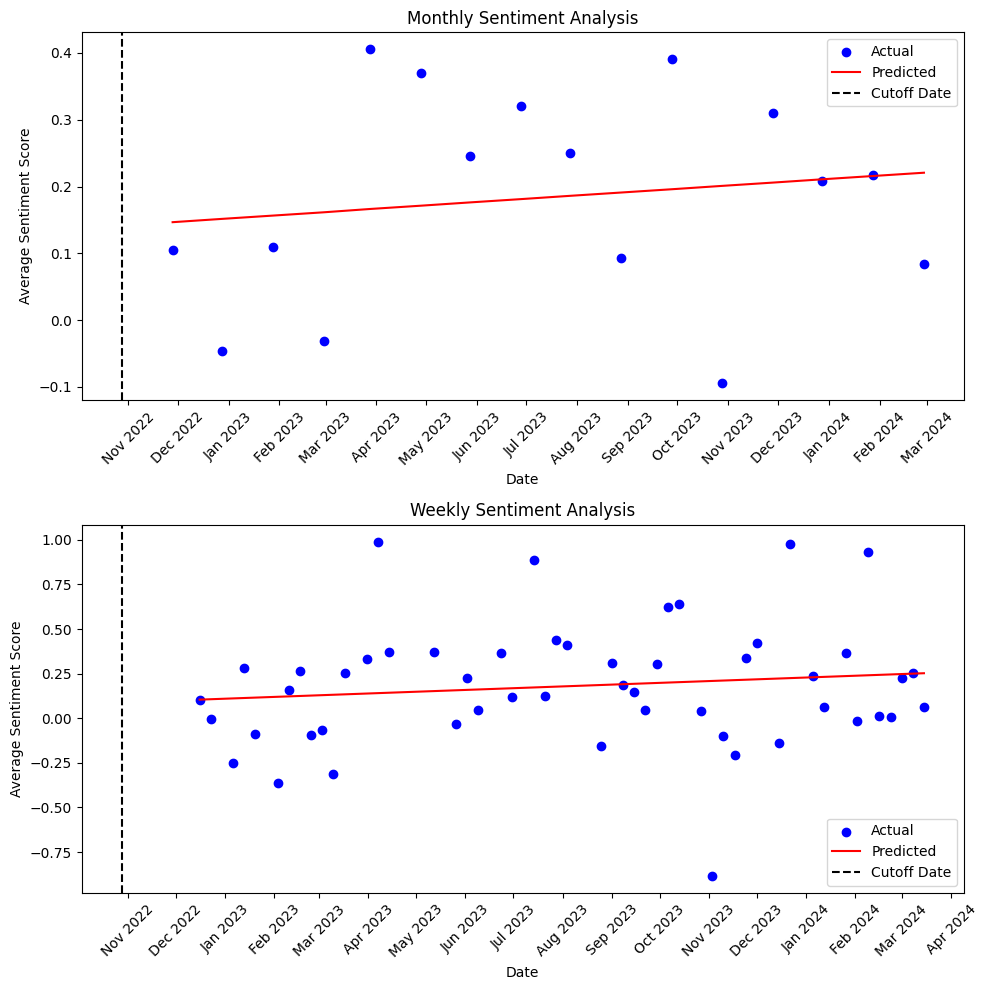

In [56]:
rdd_visualization(monthly_sentiment, weekly_sentiment, cutoff_date)

In [57]:
def rdd_sentiment_counts_analysis(preprocessed_df, sentiments=["POS", "NEG", "NEU"]):
    """
    For each sentiment category, aggregate the message counts by month and week,
    then fit a linear regression model using sklearn.
    
    Returns:
        monthly_results: dict {sentiment: (monthly_counts_df, linear_model)}
        weekly_results: dict {sentiment: (weekly_counts_df, linear_model)}
    """
    monthly_results = {}
    weekly_results = {}

    for sentiment in sentiments:
        # Filter for the specific sentiment
        df_sent = preprocessed_df[preprocessed_df["sentiment"] == sentiment]

        # --- Monthly Aggregation ---
        monthly_counts = (
            df_sent.groupby("months_since_cutoff").size()
            .reset_index(name="message_count")
        )
        monthly_counts["treatment"] = (monthly_counts["months_since_cutoff"] >= 0).astype(int)
        
        # Prepare data and fit regression model
        X_monthly = monthly_counts[["months_since_cutoff", "treatment"]].values
        y_monthly = monthly_counts["message_count"].values

        lin_model_monthly = LinearRegression()
        lin_model_monthly.fit(X_monthly, y_monthly)
        monthly_counts["predicted"] = lin_model_monthly.predict(X_monthly)

        monthly_results[sentiment] = (monthly_counts, lin_model_monthly)

        # --- Weekly Aggregation ---
        weekly_counts = (
            df_sent.groupby("weeks_since_cutoff").size()
            .reset_index(name="message_count")
        )
        weekly_counts["treatment"] = (weekly_counts["weeks_since_cutoff"] >= 0).astype(int)

        X_weekly = weekly_counts[["weeks_since_cutoff", "treatment"]].values
        y_weekly = weekly_counts["message_count"].values

        lin_model_weekly = LinearRegression()
        lin_model_weekly.fit(X_weekly, y_weekly)
        weekly_counts["predicted"] = lin_model_weekly.predict(X_weekly)

        weekly_results[sentiment] = (weekly_counts, lin_model_weekly)

    return monthly_results, weekly_results

In [58]:
def rdd_sentiment_counts_plots(monthly_results, weekly_results, cutoff_date, sentiments=["POS","NEG","NEU"]):
    """
    Plot monthly and weekly RDD graphs for each sentiment.
    The x-axis shows dates (formatted as "Mon, Year") with a tick every 1 month.
    """
    # Define formatter functions to convert numeric offset to actual date string.
    def month_year_formatter(x, pos):
        m = int(round(x))
        dt = cutoff_date + pd.DateOffset(months=m)
        return dt.strftime("%b, %Y")

    def week_year_formatter(x, pos):
        w = int(round(x))
        dt = cutoff_date + pd.Timedelta(weeks=w)
        return dt.strftime("%b, %Y")
    
    for sentiment in sentiments:
        monthly_counts, model_monthly = monthly_results[sentiment]
        weekly_counts, model_weekly = weekly_results[sentiment]

        # --- Monthly Plot ---
        plt.figure(figsize=(10, 5))
        plt.scatter(
            monthly_counts["months_since_cutoff"],
            monthly_counts["message_count"],
            color="blue", alpha=0.7, label=f"{sentiment} messages"
        )
        plt.plot(
            monthly_counts["months_since_cutoff"],
            monthly_counts["predicted"],
            color="red", label="Linear Fit"
        )
        plt.axvline(x=0, color="black", linestyle="--", label="Cutoff (JT Joined)")
        plt.xlabel("Month, Year")
        plt.ylabel("Message Count")
        plt.title(f"Monthly RDD: {sentiment} Messages")
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Tick every 1 month
        ax.xaxis.set_major_formatter(FuncFormatter(month_year_formatter))
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # --- Weekly Plot ---
        plt.figure(figsize=(10, 5))
        plt.scatter(
            weekly_counts["weeks_since_cutoff"],
            weekly_counts["message_count"],
            color="green", alpha=0.7, label=f"{sentiment} messages"
        )
        plt.plot(
            weekly_counts["weeks_since_cutoff"],
            weekly_counts["predicted"],
            color="red", label="Linear Fit"
        )
        plt.axvline(x=0, color="black", linestyle="--", label="Cutoff (JT Joined)")
        plt.xlabel("Month, Year")
        plt.ylabel("Message Count")
        plt.title(f"Weekly RDD: {sentiment} Messages")
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.MultipleLocator(4))  # Approximately every 4 weeks (~1 month)
        ax.xaxis.set_major_formatter(FuncFormatter(week_year_formatter))
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [59]:
monthly_results, weekly_results = rdd_sentiment_counts_analysis(analysis_df)

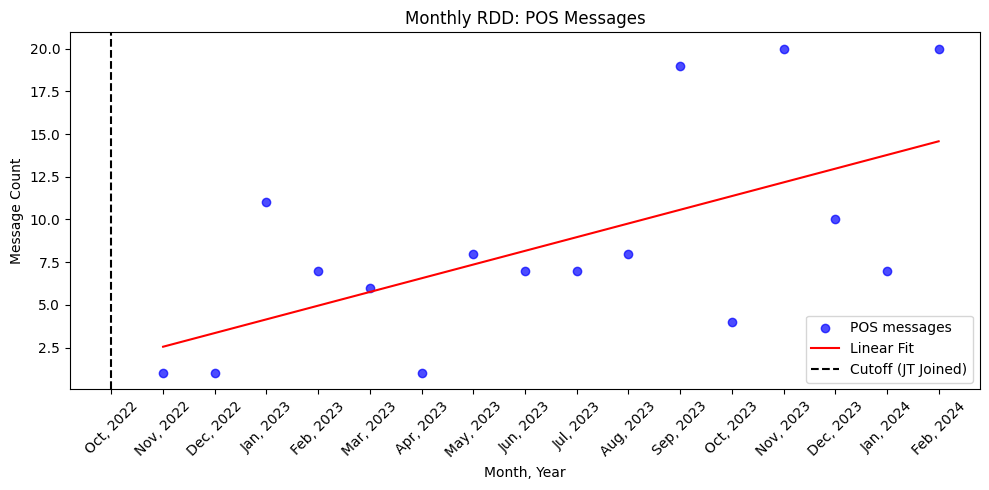

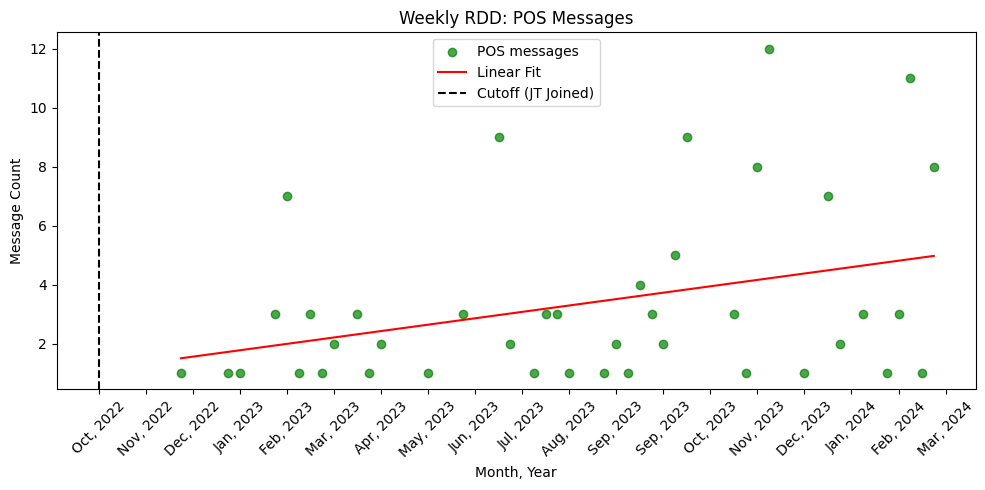

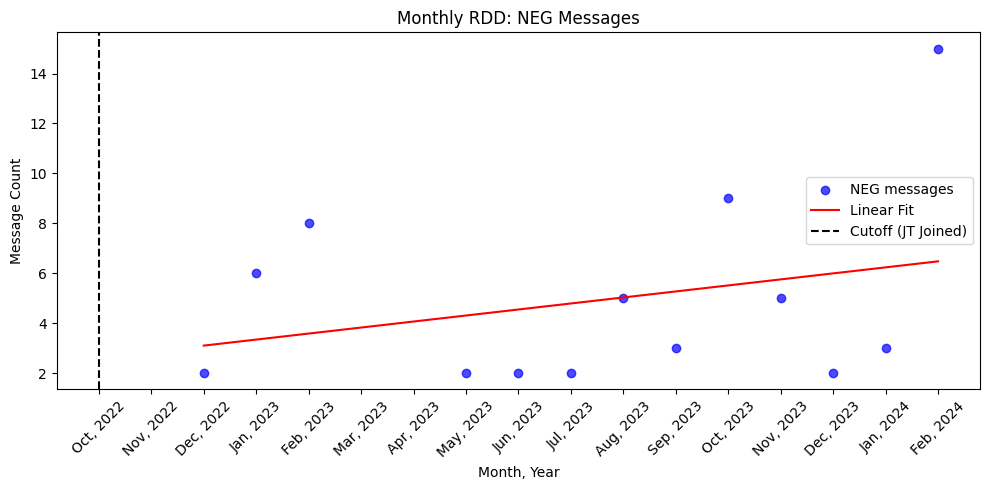

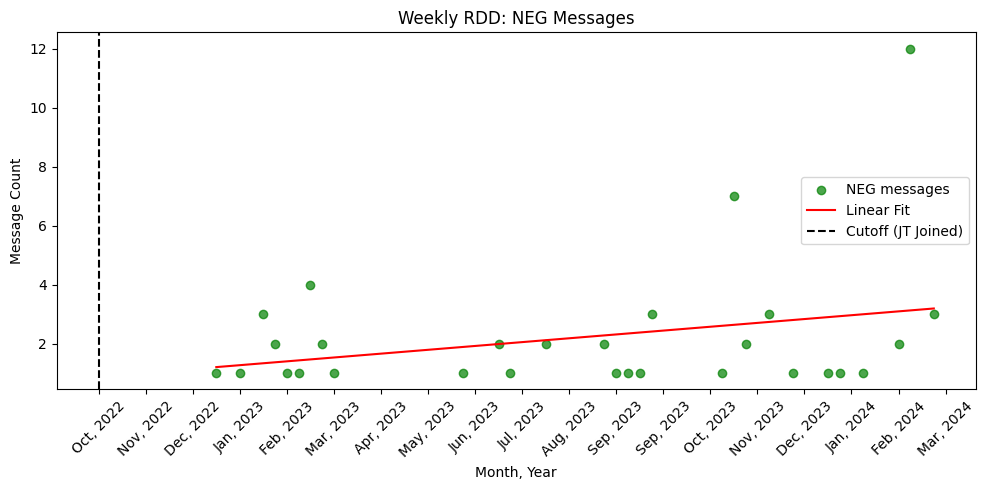

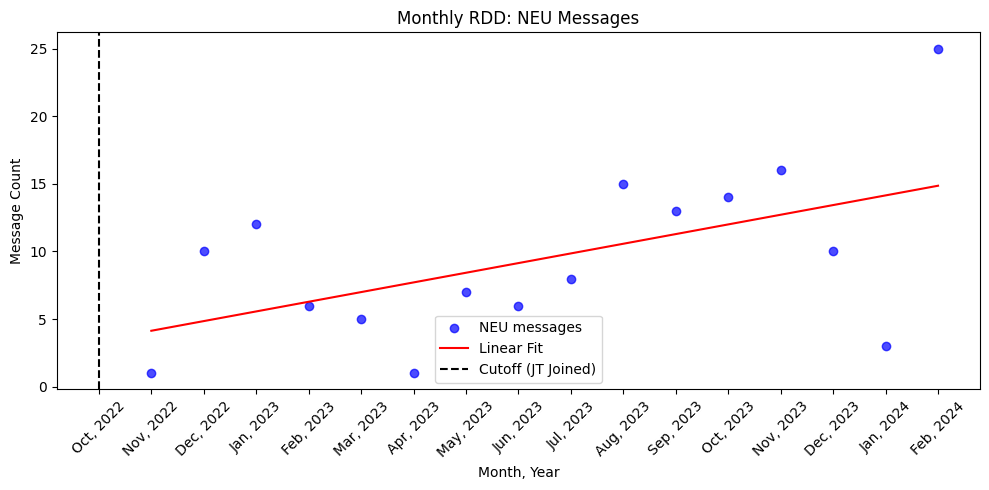

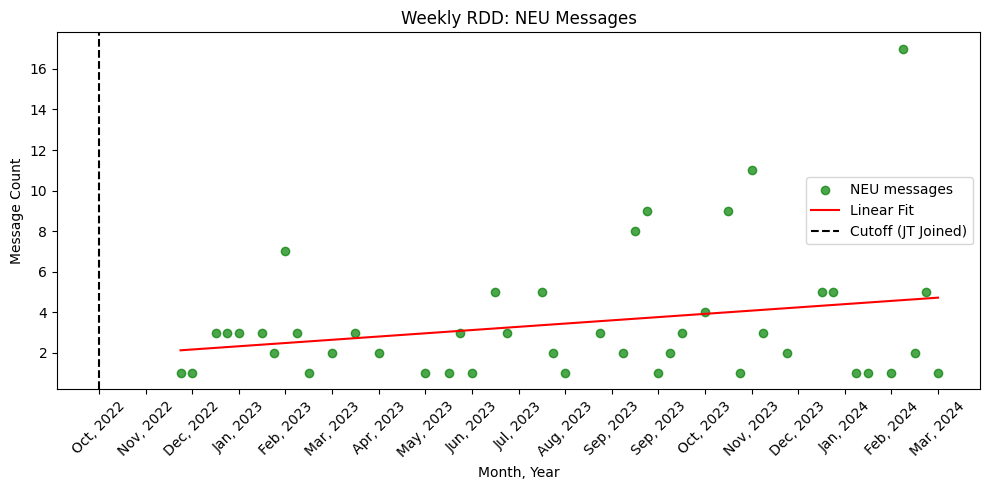

In [60]:
rdd_sentiment_counts_plots(monthly_results, weekly_results, cutoff_date)